In [1]:
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [4]:
!git clone https://www.github.com/farizrahman4u/recurrentshop.git
!cd recurrentshop && python setup.py install
!pip install git+https://github.com/farizrahman4u/seq2seq.git

fatal: destination path '.' already exists and is not an empty directory.
running install
running bdist_egg
running egg_info
creating recurrentshop.egg-info
writing recurrentshop.egg-info/PKG-INFO
writing dependency_links to recurrentshop.egg-info/dependency_links.txt
writing requirements to recurrentshop.egg-info/requires.txt
writing top-level names to recurrentshop.egg-info/top_level.txt
writing manifest file 'recurrentshop.egg-info/SOURCES.txt'
writing manifest file 'recurrentshop.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/recurrentshop
copying recurrentshop/engine.py -> build/lib/recurrentshop
copying recurrentshop/generic_utils.py -> build/lib/recurrentshop
copying recurrentshop/advanced_cells.py -> build/lib/recurrentshop
copying recurrentshop/cells.py -> build/lib/recurrentshop
copying recurrentshop/__init__.py -> build/lib/recurrentshop
copying recurrents

In [5]:
#from __future__ import absolute_import, division, print_function, unicode_literals
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.backend as K
import seq2seq
from seq2seq.models import Seq2Seq

ModuleNotFoundError: ignored

In [0]:
MAX_NUM_MENTIONS = 20
MAX_NUM_PREDICTIONS = int(MAX_NUM_MENTIONS * (MAX_NUM_MENTIONS - 1) / 2)
NUM_CPU_READ = 4
INPUT_EMBEDDINGS_SIZE = 768
BUFFER_SIZE = 100

EPOCHS = 5
VALIDATION_STEPS = 10
BATCH_SIZE = 5

DATA_FOLDER="/content/gdrive/My Drive/Puc/Projeto Final/Datasets/mention_training"

In [0]:

def input_fn_builder(input_files,
                     max_seq_length,
                     max_predictions_per_seq,
                     is_training,
                     num_cpu_threads=NUM_CPU_READ):
    """Creates an `input_fn` closure to be passed to TPUEstimator."""

    def input_fn(params):
        """The actual input function."""
        batch_size = params["batch_size"]

        name_to_features = {
            "input_embeddings":
                tf.io.FixedLenFeature(max_seq_length * INPUT_EMBEDDINGS_SIZE, tf.float32),
            "input_mask":
                tf.io.FixedLenFeature(max_seq_length, tf.int64),
            "labels":
                tf.io.FixedLenFeature(max_predictions_per_seq, tf.int64),
            "output_mask":
                tf.io.FixedLenFeature(max_predictions_per_seq, tf.int64)
        }

        # For training, we want a lot of parallel reading and shuffling.
        # For eval, we want no shuffling and parallel reading doesn't matter.
        if is_training:
            d = tf.data.Dataset.from_tensor_slices(tf.constant(input_files))
            d = d.repeat()
            d = d.shuffle(buffer_size=len(input_files))

            # `cycle_length` is the number of parallel files that get read.
            cycle_length = min(num_cpu_threads, len(input_files))

            # `sloppy` mode means that the interleaving is not exact. This adds
            # even more randomness to the training pipeline.
            d = d.apply(
                tf.data.experimental.parallel_interleave(
                    tf.data.TFRecordDataset,
                    sloppy=is_training,
                    cycle_length=cycle_length))
            d = d.shuffle(buffer_size=BUFFER_SIZE)
        else:
            d = tf.data.TFRecordDataset(input_files)
            # Since we evaluate for a fixed number of steps we don't want to encounter
            # out-of-range exceptions.
            d = d.repeat()

        # We must `drop_remainder` on training because the TPU requires fixed
        # size dimensions. For eval, we assume we are evaluating on the CPU or GPU
        # and we *don't* want to drop the remainder, otherwise we wont cover
        # every sample.
        d = d.apply(
            tf.data.experimental.map_and_batch(
                lambda record: _decode_record(record, name_to_features),
                batch_size=batch_size,
                num_parallel_batches=num_cpu_threads,
                drop_remainder=True))
        return d

    return input_fn


def _decode_record(record, name_to_features):
    """Decodes a record to a TensorFlow example."""
    example = tf.io.parse_single_example(record, name_to_features)

    # tf.Example only supports tf.int64, but the TPU only supports tf.int32.
    # So cast all int64 to int32.
    for name in list(example.keys()):
        t = example[name]
        if t.dtype == tf.int64:
            t = tf.cast(t, tf.int32)
        example[name] = t

    embeddings = tf.reshape(example["input_embeddings"], (MAX_NUM_MENTIONS, INPUT_EMBEDDINGS_SIZE))
    mask = tf.reshape(example["output_mask"], (190, 1))
    Y = tf.one_hot(example["labels"], 2)
    return {"input_embeddings": embeddings,
            "output_mask": mask}, Y


def slice_and_split_input(data_folder):
    if isinstance(data_folder, str):
        # One folder -> dev, train/test split
        files = os.listdir(data_folder)
        if len(files) == 0:
            print(f"No files found in folder {data_folder}")
            return

        files = [f"{data_folder}/{f}" for f in files if f.endswith(".tsv")]
        train_files, valid_files = train_test_split(files)
    else:
        # Two folders -> train/test already splitted
        train_files = os.listdir(data_folder[0])
        train_files = [f"{data_folder}/{f}" for f in train_files if f.endswith(".tsv")]

        valid_files = os.listdir(data_folder[1])
        valid_files = [f"{data_folder}/{f}" for f in valid_files if f.endswith(".tsv")]

    train_input = input_fn_builder(train_files,
                                   MAX_NUM_MENTIONS,
                                   MAX_NUM_PREDICTIONS,
                                   True)
    valid_input = input_fn_builder(valid_files,
                                   MAX_NUM_MENTIONS,
                                   MAX_NUM_PREDICTIONS,
                                   False)
    return train_input, valid_input


def f1_score(y_true, y_pred):
    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score


def get_model():
    embeddings = tf.keras.layers.Input(shape=(20, 768,), name="input_embeddings")
    output_mask = tf.keras.layers.Input(shape=(190, 1), name="output_mask")

    h = tf.keras.layers.Flatten()(embeddings)
    #h = tf.keras.layers.Dense(20 * 768, activation='relu')(h)
    #h = tf.keras.layers.Dropout(0.2)(h)
    h = tf.keras.layers.Dense(190 * 100, activation='relu')(h)
    h = tf.keras.layers.Reshape((190, 100))(h)
    h = tf.keras.layers.Conv1D(2, 1, strides=1)(h)

    o = tf.keras.layers.Multiply()([h, output_mask])
    # o = h

    model = tf.keras.Model([embeddings, output_mask], o)
    model.summary()

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', f1_score])
    return model


def get_data(folder):
    train_input_fn, eval_input_fn = slice_and_split_input(folder)

    train_data = train_input_fn({"batch_size": BATCH_SIZE})
    eval_data = eval_input_fn({"batch_size": BATCH_SIZE})
    return train_data, eval_data

In [0]:
model = get_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_embeddings (InputLayer)   [(None, 20, 768)]    0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 15360)        0           input_embeddings[0][0]           
__________________________________________________________________________________________________
dense (Dense)                   (None, 19000)        291859000   flatten[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 190, 100)     0           dense[0][0]                      
_____________

In [0]:
callbacks=[
  tf.keras.callbacks.EarlyStopping( patience = 4,monitor = 'val_loss', verbose = 1 ),
  tf.keras.callbacks.ReduceLROnPlateau( patience = 2, monitor = 'val_loss', verbose = 1 ),
  tf.keras.callbacks.ModelCheckpoint('model_ad.h5', verbose = 1, save_best_only = True )
]

train_data, eval_data = get_data(DATA_FOLDER)


history = model.fit(train_data, 
                    epochs=100, 
                    validation_data=eval_data, 
                    validation_steps=50, 
                    steps_per_epoch = 200,
                    callbacks=callbacks)

Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.
Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 100 steps, validate on 10 steps
Epoch 1/100
 99/100 [============================>.] - ETA: 0s - loss: 4.7532 - acc: 0.6891 - f1_score: 0.6673
Epoch 00001: val_loss improved from inf to 2.78739, saving model to model_ad.h5
100/100 [==============================] - 27s 274ms/step - loss: 4.7423 - acc: 0.6899 - f1_score: 0.6681 - val_loss: 2.7874 - val_acc: 0.8183 - val_f1_score: 0.8093
Epoch 2/100
 99/100 [======================

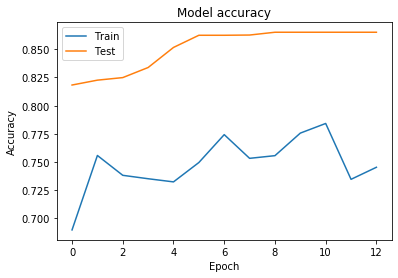

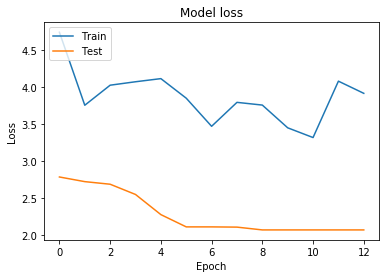

In [0]:
import matplotlib.pyplot as plt

#history = model.fit(x, y, validation_split=0.25, epochs=50, batch_size=16, verbose=1)

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()